In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#importing basic libraries
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os


Using TensorFlow backend.


In [2]:
##setting base path to data
base_path='/kaggle/input/my-sign-data/signs/'
print(os.listdir(base_path))

['25', '15', '18', '24', '10', '5', '7', '2', '0', '16', '19', '1', '13', '21', '12', '11', '17', '3', '4', '8', '20', '9', '14', '23', '22', '6']


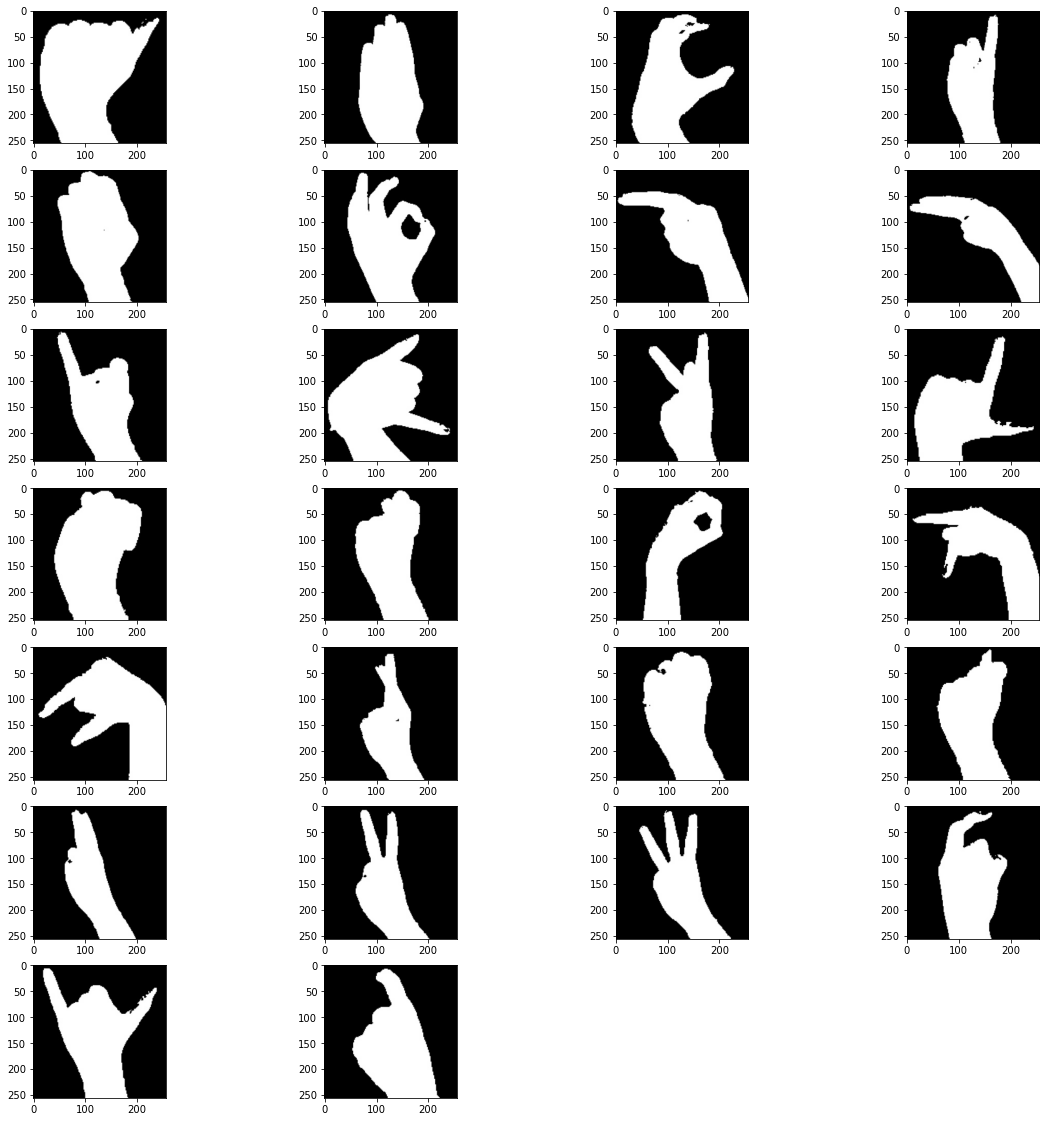

In [33]:
##plotting data
img1=load_img(base_path+'0/110.jpg')
img2=load_img(base_path+'1/110.jpg')
plt.figure(1, figsize=(20,20))
p=1
for i in range(0,7):
    for j in range(0,4):
        ind=j+i*4
        if(ind <26):
            im=load_img(base_path+str(ind)+"/700.jpg")
            plt.subplot(7,4,ind+1)
            plt.imshow(im)
plt.show()

In [34]:
##creating data generators
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(validation_split=0.1,
                             rescale=1./255,
                            rotation_range=5,
                            width_shift_range=.05,
                            height_shift_range=.05,
                            fill_mode='nearest')
batch_size=256
pic_size=256
train_generator = datagen.flow_from_directory(
    base_path, 
    subset='training',
    target_size=(pic_size,pic_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    base_path,
    subset='validation',
    target_size=(pic_size,pic_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 23587 images belonging to 26 classes.
Found 2620 images belonging to 26 classes.


In [35]:
#creating cnn model
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 26

# Initialising the CNN
model = Sequential()

model.add(Conv2D(64, (2,2), input_shape=(256,256, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(64, (4,4), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(5, 5), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(256, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(5, 5), padding='same'))
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr= 0.00156 )
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 255, 255, 64)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)      

In [36]:
##training and saving weights
epochs = 3
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = val_generator,
                                validation_steps = val_generator.n//val_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/3
92/92 [==============================] - 171s 2s/step - loss: 0.7583 - accuracy: 0.7667 - val_loss: 0.0317 - val_accuracy: 0.9770

Epoch 00001: val_accuracy improved from -inf to 0.97695, saving model to model_weights.h5
Epoch 2/3
92/92 [==============================] - 172s 2s/step - loss: 0.0725 - accuracy: 0.9761 - val_loss: 0.0314 - val_accuracy: 0.9937

Epoch 00002: val_accuracy improved from 0.97695 to 0.99365, saving model to model_weights.h5
Epoch 3/3
92/92 [==============================] - 170s 2s/step - loss: 0.0392 - accuracy: 0.9877 - val_loss: 0.0066 - val_accuracy: 0.9987

Epoch 00003: val_accuracy improved from 0.99365 to 0.99873, saving model to model_weights.h5


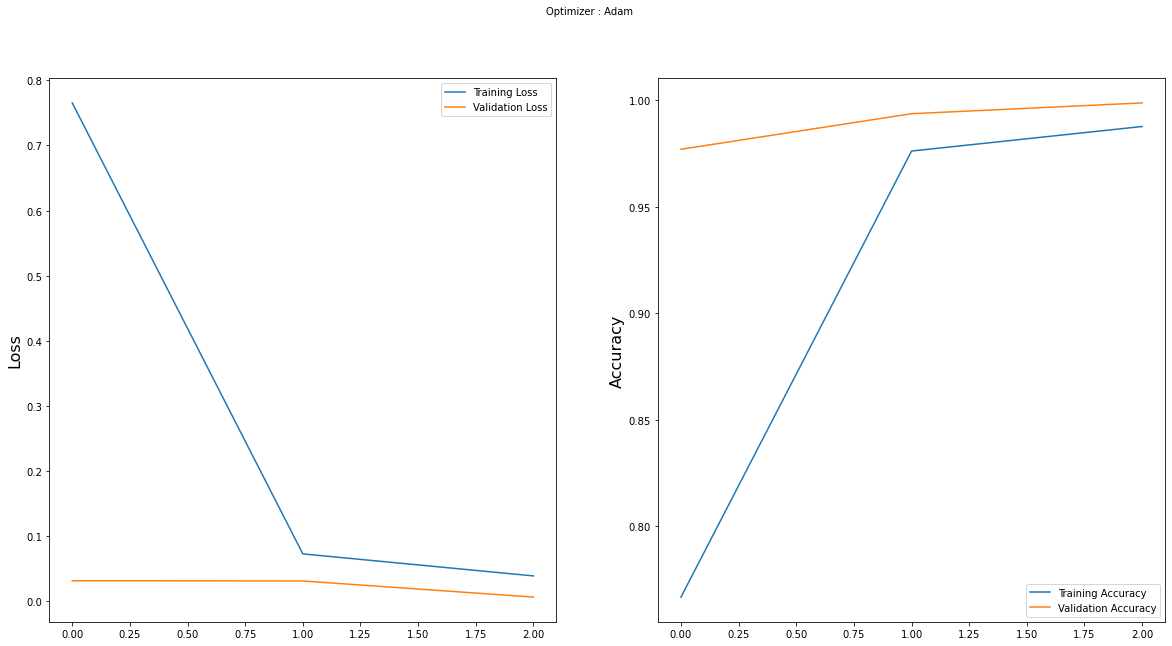

In [40]:
##plotting train and val acc and losses
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [41]:
## saving model.json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [42]:
##getting classNames
class_names = val_generator.class_indices.keys()
print(class_names)
classes=['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '3', '4', '5', '6', '7', '8', '9']

dict_keys(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '3', '4', '5', '6', '7', '8', '9'])


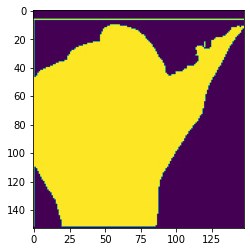

0


In [51]:
##testing with custom data
import cv2
base_path2='/kaggle/input/testing0/'
gray=cv2.imread(base_path2+'7.jpg',0)
plt.imshow(gray)
gray=cv2.resize(gray,(256,256), interpolation = cv2.INTER_AREA)
plt.show()
pred=model.predict(gray.reshape(1,256,256,1))
print(classes[pred.argmax()])

## 